# Declarations

Please run below to start up.

In [7]:
from __future__ import print_function
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
CAR_RATE = 3 # velocity of the car
TIME_CONST = 10000 #zoom in the time
RESOLUTION = 0.1

In [8]:
class Road:
    def __init__(self, city, numOfCell=10, introRate=2, remvRate=2, carRate = 2, direction = (0,1),moveProb=0.5, startPos = (0,0),interval =0.001,totalTime = 1000,name='', carRateDist={}):
        #int numOfCell, int introRate, int remvRate, int index
        self.__introRate = introRate
        self.__remvRate = remvRate
        self.carRate = carRate
        self.allCars = [] #cars in this road
        self.numOfCell = numOfCell
        self.passCar = 0 # number of the passing cars
        self.conflict = 0
        self.direction = direction
        self.startPos = startPos
        self.endPos = (startPos[0]+self.direction[0]*(self.numOfCell-1), startPos[1]+self.direction[1]*(self.numOfCell-1))
        #self.cell = {}  #cells in this road
        self.city = city
        self.time_sum_car = 0
        self.density = 0
        self.J = 0
        self.interval = interval
        self.totalTime = totalTime
        self.name = name
        self.moveProb = moveProb
        self.carRateDist = carRateDist
        for i in range(self.numOfCell):
            self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] = 1
        
    def introCar(self):
        # introduce a new car to this road
        if self.carRateDist == {}:
            if ((random.random() < self.__introRate*self.interval) and(self.city.map[self.startPos] == 1)):
                self.city.map[self.startPos] = 2
                newCar = Car(self, prob=self.moveProb, interval = self.interval,expClockRate= self.carRate)
                #self.allCars.insert(0, newCar)
                self.allCars.append(newCar)
        elif self.carRateDist['dist'] == 'normal':
            mean = self.carRateDist['mean']
            var = self.carRateDist['var']
            carRate=np.random.normal(mean,var)
            if ((random.random() < self.__introRate*self.interval) and(self.city.map[self.startPos] == 1)):
                self.city.map[self.startPos] = 2
                newCar = Car(self, prob=self.moveProb, interval = self.interval,expClockRate= carRate)
                self.allCars.append(newCar)
            
    def remvCar(self):
        # remove the car in the last cell of this road
        if ((random.random() < self.__remvRate*self.interval)and (self.city.map[self.endPos] == 2)):
            self.city.map[self.endPos] = 1
            self.allCars.pop(0)
            self.passCar += 1
            
    def showCar(self):
        for i in range(self.numOfCell):
            if self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] == 1:
                print(" | "+" ",end="")
            else:
                print(" | "+"*",end="")
        print(" |\n")
    def calculateRate(self):
        self.density = self.time_sum_car/(self.totalTime/self.interval*self.numOfCell)
        self.J = self.passCar / self.totalTime
        

        

In [9]:
class Car:
    def __init__(self, road, position=0, expClockRate=3, prob=0.5,interval =0.001):
        #int position, int expClockRate, float prob, int index (which road)
        self.__position = (road.startPos[0]+road.direction[0]*position, road.startPos[1]+road.direction[1]*position)
        self.__expClockRate = expClockRate
        self.__prob = prob
        self.__road = road
        self.interval = interval
    def moveForward(self):
        if(self.__position==self.__road.endPos):
            return "end"
        if (random.random() < self.__expClockRate*self.interval) and (random.random() < self.__prob):
            # expo & not broken
            if (self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 1): # next cell is empty
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])
                self.__road.city.map[self.__position] = 2
            elif(self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 4) and \
            self.__road.city.map[(self.__position[0]+self.__road.direction[0]*2, self.__position[1]+self.__road.direction[1]*2)] == 1:#green light
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0]*2, self.__position[1]+self.__road.direction[1]*2)
                self.__road.city.map[self.__position] = 2
            else:
                return "conflict"
                
        return "move"

In [10]:
class City:
    def __init__(self, l=100, w=100,totalTime = 1000,interval = 0.001,name=''):
        self.l = l
        self.w = w
        self.map = {(i,j):0 for i in range(self.l) for j in range(self.w)} 
        self.roads=[]
        self.totalTime = totalTime
        self.interval = interval
        self.name = name
        self.J = 0
        self.density = 0
        self.time_sum_car = 0
        self.numOfCell = 0
        self.passCar = 0
    def showCity(self):
        rx = []
        ry = []
        cx = []
        cy = []
        lx = []
        ly = []
        gx = []
        gy = []
        for i in self.map:
            if self.map[i] != 0:
                rx.append(i[0])
                ry.append(i[1])
            if self.map[i] == 2:
                cx.append(i[0])
                cy.append(i[1])
            elif self.map[i] == 3:
                lx.append(i[0])
                ly.append(i[1])
            elif self.map[i] == 4:
                gx.append(i[0])
                gy.append(i[1])
                
            
        plt.plot(rx, ry, marker="o",color="navy",linestyle=" ",markersize=2)
        plt.plot(cx, cy, marker="*",color="y",linestyle=" ")
        plt.plot(lx, ly, marker="s",color="r",linestyle=" ")
        plt.plot(gx, gy, marker="s",color="lightgreen",linestyle=" ")
        plt.show()
        
    def showCitySub(self):
        ax.clear()
        rx = []
        ry = []
        cx = []
        cy = []
        lx = []
        ly = []
        gx = []
        gy = []
        for i in self.map:
            if self.map[i] != 0:
                rx.append(i[0])
                ry.append(i[1])
            if self.map[i] == 2:
                cx.append(i[0])
                cy.append(i[1])
            elif self.map[i] == 3:
                lx.append(i[0])
                ly.append(i[1])
            elif self.map[i] == 4:
                gx.append(i[0])
                gy.append(i[1])
            
        ax.plot(rx, ry, marker="o",color="navy",linestyle=" ",markersize=4)
        ax.plot(cx, cy, marker="*",color="y",linestyle=" ")
        ax.plot(lx, ly, marker="s",color="r",linestyle=" ")
        ax.plot(gx, gy, marker="s",color="lightgreen",linestyle=" ")
        fig.canvas.draw()
    
    def createRoad(self,numOfCell=10, introRate=2, remvRate=2,carRate = 2,moveProb=0.5, direction = (0,1), startPos = (0,0),name = '', carRateDist ={}):
        newRoad = Road(self, numOfCell=numOfCell, introRate=introRate, remvRate=remvRate, direction = direction, \
                       startPos = startPos,moveProb=moveProb,carRate =carRate, interval = self.interval,\
                       totalTime = self.totalTime, name = name, carRateDist =dist)
        self.roads.append(newRoad)
        self.numOfCell += newRoad.numOfCell
    def introCar(self):
        for road in self.roads:
            road.introCar()
            
    def remvCar(self):
        self.passCar = 0
        for road in self.roads:
            road.remvCar()
            self.passCar += road.passCar
    def moveCar(self):
        for road in self.roads:
            for car in road.allCars:
                ret = car.moveForward()
                if ret =="conflict":
                    road.conflict += 1
    def Time_sum_car(self):
        for road in self.roads:
            road.time_sum_car += len(road.allCars)
    def calculateRate(self):
        self.time_sum_car = 0
        for road in self.roads:
            road.calculateRate()
            self.time_sum_car += road.time_sum_car
        self.density = self.time_sum_car/(self.totalTime/self.interval*self.numOfCell)
        self.J = self.passCar / self.totalTime
    def light(self, position):
        if random.random < 0.5:
            self.City.map[position] = 3
        else:
            self.City.map[position] = 1
            
    def crossRoadLight(self, position1, position2):
        if random.random() < 0.5:
            self.map[position1] = 3
            self.map[position2] = 1
        else:
            self.map[position1] = 1
            self.map[position2] = 3
            
    def crossRoadLight2(self, position1, position2, position3, position4, counter): #1=3, 2=4
        if(counter % 50 <= 24):
            self.map[position1] = 3
            self.map[position2] = 4
            self.map[position3] = 3
            self.map[position4] = 4
        else:
            self.map[position1] = 4
            self.map[position2] = 3
            self.map[position3] = 4
            self.map[position4] = 3
    def freshMap(self):
        del(self.roads[:])
        self.numOfCell = 0
        self.roads=[]
        self.map = {(i,j):0 for i in range(self.l) for j in range(self.w)} 

In [5]:

TOTAL_TIME = 100
interval = 0.01

SF = City(totalTime=TOTAL_TIME, interval=interval, name = 'SF')
x = np.arange(0, 30, 3)
y = np.arange(0, 30, 3)
j = []
d = []
print("_"*100)
for ir in x:
    jj = []
    dd = []
    for rr in y:
        SF.freshMap()
        SF.createRoad(introRate=ir, remvRate=rr, startPos = (0,-5),carRate = 25,numOfCell=10, moveProb=0.5 )
        startTime = 0
        Stop = False
        currentTime = startTime - interval
        while not Stop:
            currentTime = currentTime+interval
            if currentTime > TOTAL_TIME:
                Stop = True
            SF.introCar()
            SF.remvCar()
            SF.moveCar()
            SF.Time_sum_car()
        SF.calculateRate()
        jj.append(SF.J)
        dd.append(SF.density)
        print ("|",end="")
    j.append(jj)
    d.append(dd)
print ('\n\nSimluation Done!')

NameError: name 'City' is not defined

<function matplotlib.pyplot.show>

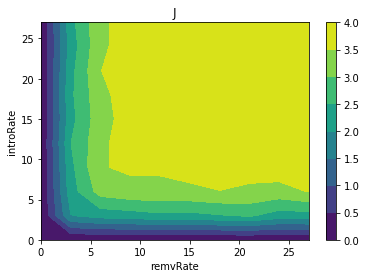

In [48]:
array_z = np.array(j)
array_x,array_y = np.meshgrid(x,y)
surf = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("J")
plt.colorbar()
plt.savefig('1roadJ.png')
plt.show

<function matplotlib.pyplot.show>

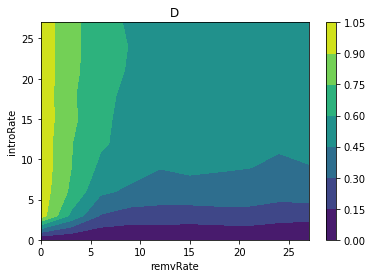

In [49]:
array_z = np.array(d)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("D")
plt.colorbar()
plt.savefig('1roadD.png')
plt.show


What about crossroads? Let's see what will happen if there are two roads coincident with each other.

In [50]:

TOTAL_TIME = 100
interval = 0.01
SF = City(totalTime=TOTAL_TIME, interval=interval, name = 'SF')
x = np.arange(0, 30, 3)
y = np.arange(0, 30, 3)
j = []
d = []
print("_"*100)
for ir in x:
    jj = []
    dd = []
    for rr in y:
        SF.freshMap()
        SF.createRoad(introRate=ir, remvRate=rr, startPos = (0,-5),carRate = 25,numOfCell=10, moveProb=0.5 )
        SF.createRoad(introRate=ir, remvRate=rr, direction = (1,0), startPos = (-5,0), carRate =25, numOfCell=10, moveProb=0.5)
        startTime = 0
        Stop = False
        currentTime = startTime - interval
        while not Stop:
            currentTime = currentTime+interval
            if currentTime > TOTAL_TIME:
                Stop = True
            SF.introCar()
            SF.remvCar()
            SF.moveCar()
            SF.Time_sum_car()
        SF.calculateRate()
        jj.append(SF.J)
        dd.append(SF.density)
        print ("|",end="")
    j.append(jj)
    d.append(dd)
print ('\n\nSimluation Done!')

____________________________________________________________________________________________________
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Simluation Done!


<function matplotlib.pyplot.show>

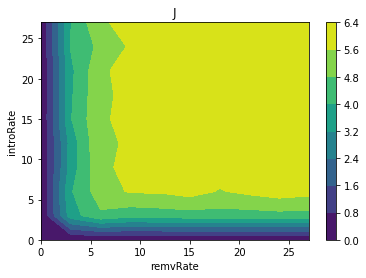

In [51]:
array_z = np.array(j)
array_x,array_y = np.meshgrid(x,y)
surf = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("J")
plt.colorbar()
plt.savefig('2roadJ.png')
plt.show

<function matplotlib.pyplot.show>

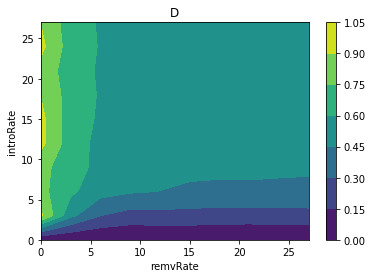

In [52]:
array_z = np.array(d)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("D")
plt.colorbar()
plt.savefig('2roadD.png')
plt.show

In [53]:

TOTAL_TIME = 500
interval = 0.01

SF = City(totalTime=TOTAL_TIME, interval=interval, name = 'SF')
x = np.arange(0, 30, 3)
y = np.arange(0, 30, 3)
j = []
d = []
print("_"*100)

for r in y:
    jj = []
    dd = []
    for cr in x:
        SF.freshMap()
        SF.createRoad(introRate=r, remvRate=r, startPos = (0,-5),carRate = cr,numOfCell=10, moveProb=0.5 )
        startTime = 0
        Stop = False
        currentTime = startTime - interval
        while not Stop:
            currentTime = currentTime+interval
            if currentTime > TOTAL_TIME:
                Stop = True
            SF.introCar()
            SF.remvCar()
            SF.moveCar()
            SF.Time_sum_car()
        SF.calculateRate()
        jj.append(SF.J)
        dd.append(SF.density)
        print ("|",end="")
    j.append(jj)
    d.append(dd)

print ('\n\nSimluation Done!')

____________________________________________________________________________________________________
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Simluation Done!


<function matplotlib.pyplot.show>

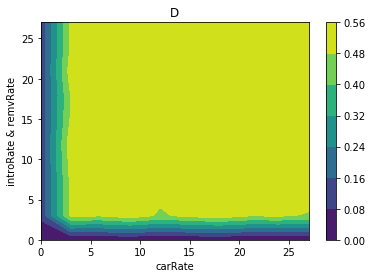

In [54]:
array_z = np.array(d)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('carRate')
plt.ylabel('introRate & remvRate')
plt.title("D")   
plt.colorbar()
plt.savefig('1roadD_carRatevsrate.png')
plt.show

<function matplotlib.pyplot.show>

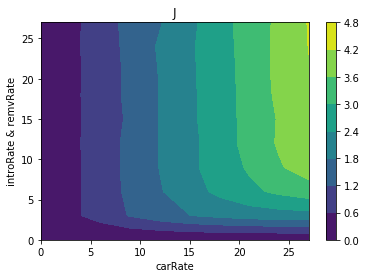

In [56]:
array_z = np.array(j)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('carRate')
plt.ylabel('introRate & remvRate')
plt.title("J")
plt.colorbar()
plt.savefig('1roadJ_carRatevsrate).png')
plt.show

In [57]:

TOTAL_TIME = 500
interval = 0.01

SF = City(totalTime=TOTAL_TIME, interval=interval, name = 'SF')
x = np.arange(0, 30, 3)
y = np.arange(0, 30, 3)
j = []
d = []
print("_"*100)

for ir in y:
    jj = []
    dd = []
    for cr in x:
        SF.freshMap()
        SF.createRoad(introRate=ir, remvRate=25, startPos = (0,-5),carRate = cr,numOfCell=10, moveProb=0.5 )
        startTime = 0
        Stop = False
        currentTime = startTime - interval
        while not Stop:
            currentTime = currentTime+interval
            if currentTime > TOTAL_TIME:
                Stop = True
            SF.introCar()
            SF.remvCar()
            SF.moveCar()
            SF.Time_sum_car()
        SF.calculateRate()
        jj.append(SF.J)
        dd.append(SF.density)
        print ("|",end="")
    j.append(jj)
    d.append(dd)

print ('\n\nSimluation Done!')

____________________________________________________________________________________________________
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Simluation Done!


<function matplotlib.pyplot.show>

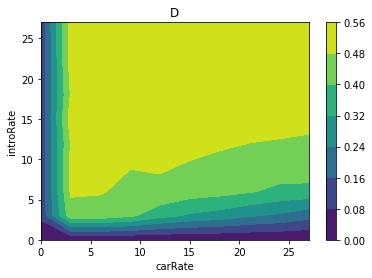

In [58]:
array_z = np.array(d)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('carRate')
plt.ylabel('introRate')
plt.title("D")   
plt.colorbar()
plt.savefig('1roadD_carRatevsintroRate.png')
plt.show

<function matplotlib.pyplot.show>

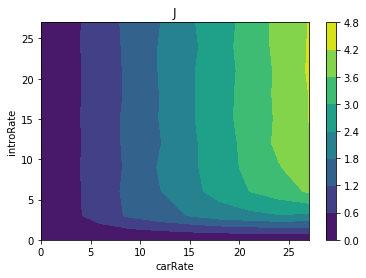

In [59]:
array_z = np.array(j)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('carRate')
plt.ylabel('introRate')
plt.title("J")
plt.colorbar()
plt.savefig('1roadJ_carRatevsintroRate).png')
plt.show

In [60]:

TOTAL_TIME = 500
interval = 0.01

SF = City(totalTime=TOTAL_TIME, interval=interval, name = 'SF')
x = np.arange(0, 30, 3)
y = np.arange(0, 30, 3)
j = []
d = []
print("_"*100)

for rr in y:
    jj = []
    dd = []
    for cr in x:
        SF.freshMap()
        SF.createRoad(introRate=25, remvRate=rr, startPos = (0,-5),carRate = cr,numOfCell=10, moveProb=0.5 )
        startTime = 0
        Stop = False
        currentTime = startTime - interval
        while not Stop:
            currentTime = currentTime+interval
            if currentTime > TOTAL_TIME:
                Stop = True
            SF.introCar()
            SF.remvCar()
            SF.moveCar()
            SF.Time_sum_car()
        SF.calculateRate()
        jj.append(SF.J)
        dd.append(SF.density)
        print ("|",end="")
    j.append(jj)
    d.append(dd)

print ('\n\nSimluation Done!')

____________________________________________________________________________________________________
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Simluation Done!


<function matplotlib.pyplot.show>

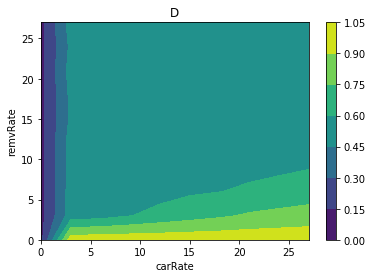

In [61]:
array_z = np.array(d)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('carRate')
plt.ylabel('remvRate')
plt.title("D")   
plt.colorbar()
plt.savefig('1roadD_carRatevsremvRate.png')
plt.show

<function matplotlib.pyplot.show>

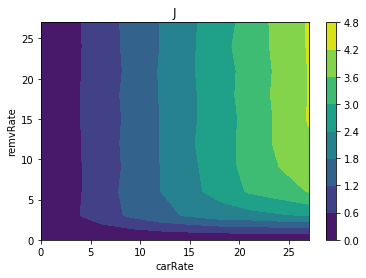

In [62]:
array_z = np.array(j)
array_x,array_y = np.meshgrid(y,x)
surf2 = plt.contourf(array_x,array_y,array_z)
plt.xlabel('carRate')
plt.ylabel('remvRate')
plt.title("J")
plt.colorbar()
plt.savefig('1roadJ_carRatevsremvRate).png')
plt.show

<IPython.core.display.Javascript object>


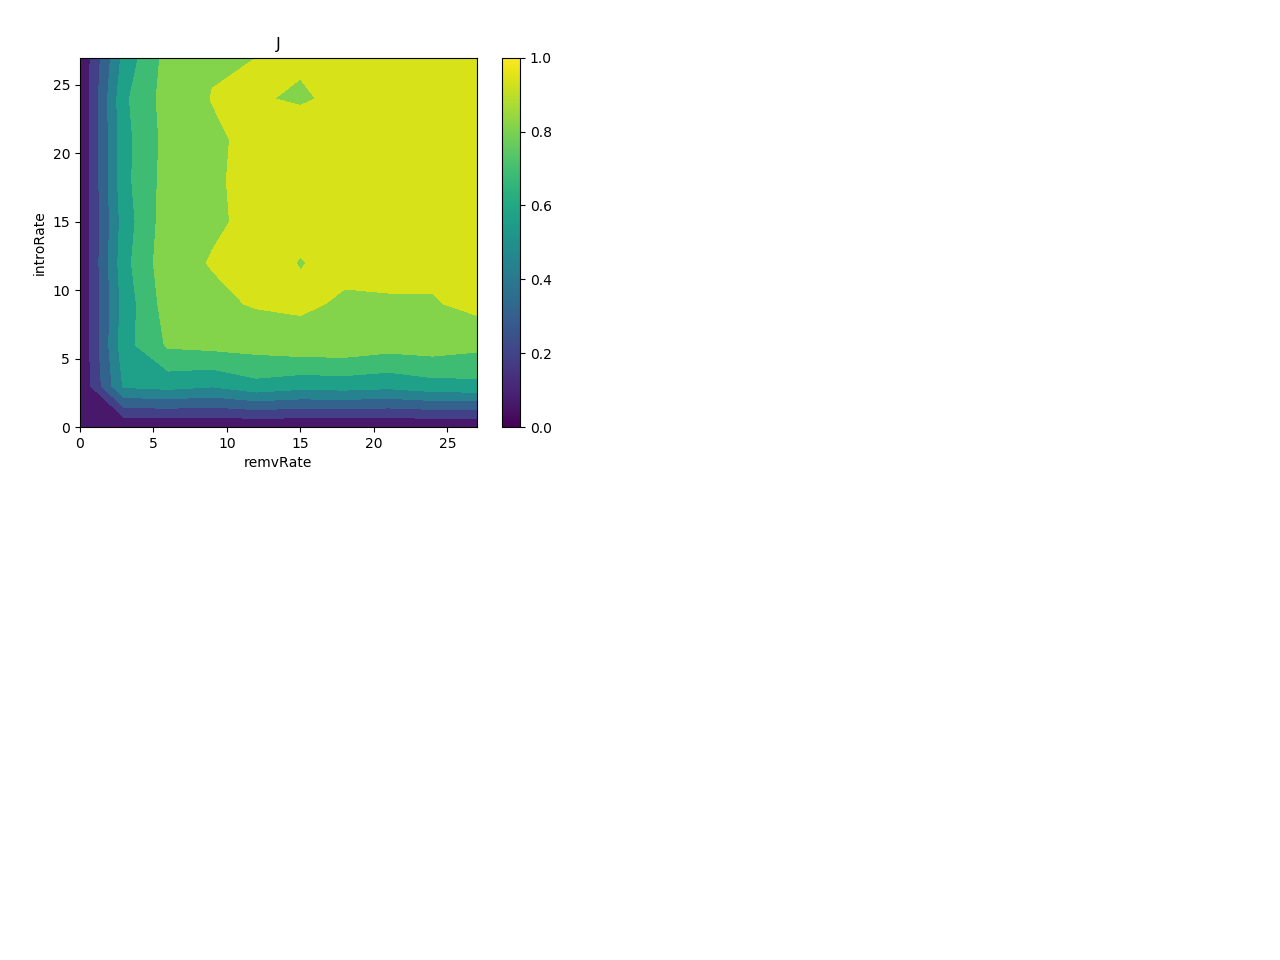

KeyboardInterrupt: 

In [27]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

TOTAL_TIME = 500
interval = 0.01

x = np.arange(0, 30, 3)
y = np.arange(0, 30, 3)
dist = {'dist':'normal','mean':25,'var':5}
# print("_"*100)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
cb=fig.colorbar(plt.cm.ScalarMappable(), ax=ax)

for t in range(10,TOTAL_TIME,10):
    j = []
    d = []
    SF = City(totalTime=t, interval=interval, name = 'SF')
    for ir in x:
        jj = []
        dd = []
        for rr in y:
            SF.freshMap()
            SF.createRoad(introRate=ir, remvRate=rr, startPos = (0,-5),carRate = 25,numOfCell=10, moveProb=0.5, carRateDist =dist )
            startTime = 0
            Stop = False
            currentTime = startTime - interval
            while not Stop:
                currentTime = currentTime+interval
                if currentTime > t:
                    Stop = True
                SF.introCar()
                SF.remvCar()
                SF.moveCar()
                SF.Time_sum_car()
            SF.calculateRate()
            jj.append(SF.J)
            dd.append(SF.density)
#             print ("|",end="")
        j.append(jj)
        d.append(dd)
    
    ax.clear()
#     cb.remove()
    array_z = np.array(j)
    array_x,array_y = np.meshgrid(x,y)
    surf = ax.contourf(array_x,array_y,array_z)
    plt.xlabel('remvRate')
    plt.ylabel('introRate')
    plt.title("J")
#     ax.colorbar()
#     cb=fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
#     plt.savefig('1roadJ_carRateNormal.png')
#     ax.show()
    fig.canvas.draw()
    
print ('\n\nSimluation Done!')

<function matplotlib.pyplot.show>

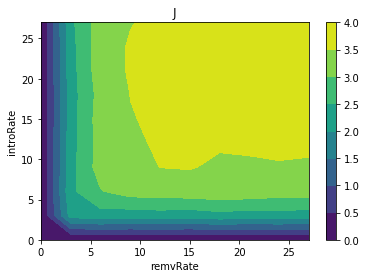

In [13]:
array_z = np.array(j)
array_x,array_y = np.meshgrid(x,y)
surf = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("J")
plt.colorbar()
plt.savefig('1roadJ_carRateNormal.png')
plt.show

<function matplotlib.pyplot.show>

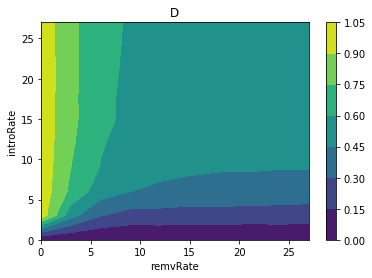

In [14]:
array_z = np.array(d)
array_x,array_y = np.meshgrid(x,y)
surf = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("D")
plt.colorbar()
plt.savefig('1roadD_carRateNormal.png')
plt.show